In [1]:
from __future__ import unicode_literals
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import wave
import sys
import librosa
import librosa.display
import os
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils import data

### Obtaining Data (conv_mfcc.py)

The functions below will be used to convert our .wav files into the mfccs that we desire.

In [2]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

#Extract mfcc features(mfcc, first time derivative, second time derivative) from the audio
def wav_to_mfcc(audio, sample_rate, **kwargs):
    audio = normalize_audio(audio)
    mfccs = librosa.feature.mfcc(audio, sample_rate, n_mfcc = 13,**kwargs)
    delta = librosa.feature.delta(mfccs)
    delta_delta = librosa.feature.delta(mfccs, order = 2)
    return np.array([mfccs,delta,delta_delta])

#Create a mfcc plot
def plot_mfcc(mfcc):
    librosa.display.specshow(mfcc, x_axis = 'time')
    plt.colorbar()
    plt.title('Normalized MFCC')
    plt.tight_layout()
    plt.show()

#Create a plot of the original sound signal
def plot_wav(audio,sample_rate):
    audio = normalize_audio(audio)
    plt.figure(figsize=(15,4))
    plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
    plt.grid(True)
    plt.show()

In [3]:
'''The following code will extract MFCC features from each sound files in the raw data folder
   with the specified parameters: n_mfcc = 13, 20ms fft window length, 10ms fft hop length;
   Output will be saved in the processed data folder as numpy arrays of form (mfcc, delta, delta_delta)
'''
min_length = 100000000
for i in range(9, 13):
    for files in os.listdir('data/raw data%i/hyenas/' % (i)):
        audio,sample_rate = librosa.load('data/raw data%i/hyenas/%s' % (i, files))
        #Will be computing mfcc features for each frame with length of 10ms
        n_fft = int(sample_rate*0.02)
        #hop_length = # of samples bet'n each frame
        hop_length = int(n_fft//2)
        features = wav_to_mfcc(audio,sample_rate)
        if(features.shape[2] < min_length):
            min_length = features.shape[2]
        np.save('data/processed data%i/hyenas/%s'% (i, files),features)


    for files in os.listdir('data/raw data%i/lions/' % (i)):
        audio, sample_rate = librosa.load('data/raw data%i/lions/%s' % (i, files))
        # Will be computing mfcc features for each frame with length of 10ms
        n_fft = int(sample_rate * 0.02)
        # hop_length = # of samples bet'n each frame
        hop_length = int(n_fft//2)
        features = wav_to_mfcc(audio, sample_rate)
        if(features.shape[2] < min_length):
            min_length = features.shape[2]
        np.save('data/processed data%i/lions/%s' % (i, files), features)

print('Finished extracting MFCCs')
print('Minimum length is %i' % (min_length))

Finished extracting MFCCs
Minimum length is 430


Now extracting the mfccs as well as its 1st and 2nd gradient from the processed data. Note that a label of 0 = hyena, and a label of 1 = lions

In [4]:
# TRAINING DATA
mfccs = []
deltas = []
delta_deltas = []
y = []
X = []
min_length = 430
min_shape = 1000

for i in range(9, 12):
    path_hyena = ('data/processed data%i/hyenas/' %(i))
    path_lion = ('data/processed data%i/lions/' %(i))
    for file in os.listdir(path_hyena):
        hyena = np.load(path_hyena + file)
        if min_shape > hyena[0].shape[1]:
            min_shape = hyena[0].shape[1]
        mfcc = np.asarray(hyena[0][:, :min_length])
        delta = np.asarray(hyena[1][:, :min_length])
        delta_delta = np.asarray(hyena[2][:, :min_length])
        mfccs.append(mfcc)
        deltas.append(delta)
        delta_deltas.append(delta_delta)
        X.append([mfcc, delta, delta_delta])
        y.append(0)

    for file in os.listdir(path_lion):
        lion = np.load(path_lion + file)
        if min_shape > lion[0].shape[1]:
            min_shape = lion[0].shape[1]
        mfcc = np.asarray(lion[0][:, :min_length])
        delta = np.asarray(lion[1][:, :min_length])
        delta_delta = np.asarray(lion[2][:, :min_length])
        mfccs.append(mfcc)
        deltas.append(delta)
        delta_deltas.append(delta_delta)
        X.append([mfcc, delta, delta_delta])
        y.append(1)

# TEST DATA
y_test = []
X_test = []
path_hyena = ('data/processed data12/hyenas/' )
path_lion = ('data/processed data12/lions/' )
for file in os.listdir(path_hyena):
        hyena = np.load(path_hyena + file)
        if min_shape > hyena[0].shape[1]:
            min_shape = hyena[0].shape[1]
        mfcc = np.asarray(hyena[0][:, :min_length])
        delta = np.asarray(hyena[1][:, :min_length])
        delta_delta = np.asarray(hyena[2][:, :min_length])
        mfccs.append(mfcc)
        deltas.append(delta)
        delta_deltas.append(delta_delta)
        X_test.append([mfcc, delta, delta_delta])
        y_test.append(0)

for file in os.listdir(path_lion):
        lion = np.load(path_lion + file)
        if min_shape > lion[0].shape[1]:
            min_shape = lion[0].shape[1]
        mfcc = np.asarray(lion[0][:, :min_length])
        delta = np.asarray(lion[1][:, :min_length])
        delta_delta = np.asarray(lion[2][:, :min_length])
        mfccs.append(mfcc)
        deltas.append(delta)
        delta_deltas.append(delta_delta)
        X_test.append([mfcc, delta, delta_delta])
        y_test.append(1)

So now we have obtained the following for our input data:
1. **mfccs[i]**: the mel-frequency cepstrum coefficients for a single audio file indexed at *i*
2. **deltas[i]**: the first derivative of the mfccs 
3. **delta_deltas[i]**: the second derivative of the mfccs

and our associated label:
1. **label[i]**: the audio file indexed at *i* will be 1 if it is a lion and 0 if it is a hyena

Now splitting our data and randomizing it:

In [5]:
split_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

X = np.asarray(X)
X_test = np.asarray(X_test)
y = np.asarray(y)
y_test = np.asarray(y_test)

for train_index, val_index in split_val.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]



# printing out number of classes in each
print('Training has %d samples of class 0 and %d samples of class 1' % (
np.unique(y_train, return_counts=True)[1][0], np.unique(y_train, return_counts=True)[1][1]))
print('Validation has %d samples of class 0 and %d samples of class 1' % (
np.unique(y_val, return_counts=True)[1][0], np.unique(y_val, return_counts=True)[1][1]))

Training has 400 samples of class 0 and 400 samples of class 1
Validation has 100 samples of class 0 and 100 samples of class 1


In [6]:
class testingDataset(data.Dataset):
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        sample_label = self.labels[index]
        return sample, sample_label

### Network (local_model.py)

In [13]:
class Net(nn.Module):
    def __init__(self, mfcc_total):
        super(Net, self).__init__()
        self.conv_mfcc = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(mfcc_total, 10), stride=5)
        self.conv_delta = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(mfcc_total, 10), stride=5)
        self.conv_delta_delta = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(mfcc_total, 10), stride=5)

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3,10), stride=3)
        self.conv_2 = nn.Conv2d(in_channels=10, out_channels=5, kernel_size=(1,10), stride=1)
        self.conv_3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,10),stride=1)
        self.conv_4 = nn.Conv2d(in_channels=256,out_channels = 512, kernel_size = (1,3),stride=2)
        self.fc1 = nn.Linear(85, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, mfcc, delta, delta_delta):
        # Compressing features into 3x300 matrix
        mfcc_features = self.conv_mfcc(mfcc)
        delta_features = self.conv_delta(delta)
        delta_delta_features = self.conv_delta_delta(delta_delta)
        features = torch.cat((mfcc_features, delta_features, delta_delta_features),2)
        features = F.relu(self.conv_1(features))
        features = F.relu(self.conv_2(features))
        #features = F.relu(self.conv_3(features))
        #features = F.relu(self.conv_4(features)).squeeze()
        features = features.view(-1,85)
        features = self.fc1(features)
        features = torch.sigmoid(self.fc2(features))
        return features

def load_model(lr, seed, mfcc_total):
    torch.manual_seed(seed)
    model = Net(mfcc_total)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return model, loss_function, optimizer


def plot_accuracy(epoch, train_accuracy, val_accuracy):
    plt.plot(epoch, train_accuracy, label = 'train')
    plt.plot(epoch, val_accuracy, label = 'val')
    plt.title('Accuracy vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss(epoch, train_loss, val_loss):
    plt.plot(epoch, train_loss, label = 'train')
    plt.plot(epoch, val_loss, label = 'val')
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


### Training (local.py)

In [19]:
###### SET HYPERPARAMETERS HERE ######
lr = 0.0001
seed = 1
mfcc_total = 10
epochs = 15
batch_size = 30

Final Train Loss: 0.523641
Final Train Accuracy: 0.966250
Final Valdiation Loss: 0.514148
Final Validation Accuracy: 0.985000
Test Loss: 0.528058
Test Accuracy: 0.950000


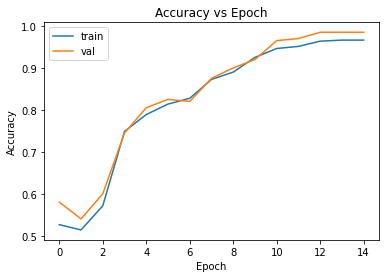

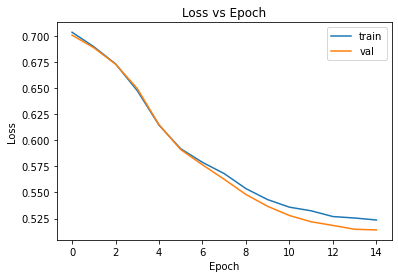

In [20]:
def main_test():
    torch.manual_seed(seed)
    model, loss_function, optimizer = load_model(lr, seed, mfcc_total)
    train_dataset = testingDataset(X_train,y_train)
    train_loader = data.DataLoader(train_dataset,batch_size = batch_size, shuffle=True)
    valid_dataset = testingDataset(X_val,y_val)
    valid_loader = data.DataLoader(valid_dataset,batch_size = batch_size)
    test_dataset = testingDataset(X_test, y_test)
    test_loader = data.DataLoader(test_dataset,batch_size = test_dataset.__len__())
    
    tloss = []
    tacc = []
    vloss = []
    vacc = []
    for epoch in range(epochs):
        taccumloss = 0
        tcorrect = 0
        ttotal = 0
        tnumberofBatches = 0
        vnumberofBatches = 0
        vaccumloss = 0
        vcorrect = 0
        vtotal = 0
        for i, batch in enumerate(train_loader):
            tmp_prediction = []
            input, label = batch
            optimizer.zero_grad()
            # Obtaining our mfcc, delta and delta_delta from X and converting to tensor
            for j in range(len(input)):
                mfcc = input[j][0].unsqueeze(0).unsqueeze(0)
                delta = input[j][1].unsqueeze(0).unsqueeze(0)
                delta_delta = input[j][2].unsqueeze(0).unsqueeze(0)
                prediction = model(mfcc,delta,delta_delta)
                tmp_prediction.append(prediction)
            tmp_prediction = torch.stack(tmp_prediction)
            loss = loss_function(input = tmp_prediction.squeeze(),target = label.float())
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for batch in train_loader:
                tmp_prediction = []
                input, label = batch
                optimizer.zero_grad()
                # Obtaining our mfcc, delta and delta_delta from X and converting to tensor
                for j in range(len(input)):
                    mfcc = input[j][0].unsqueeze(0).unsqueeze(0)
                    delta = input[j][1].unsqueeze(0).unsqueeze(0)
                    delta_delta = input[j][2].unsqueeze(0).unsqueeze(0)
                    prediction = model(mfcc, delta, delta_delta)
                    tmp_prediction.append(prediction)
                tmp_prediction = torch.tensor(tmp_prediction, requires_grad=True)
                loss = loss_function(input=tmp_prediction, target=label.float())
                taccumloss += loss.item()
                for i in range(len(tmp_prediction)):
                    if tmp_prediction[i] >= 0.5 and label[i] == 1:
                        tcorrect += 1
                    elif tmp_prediction[i] < 0.5 and label[i] == 0:
                        tcorrect += 1
                ttotal += label.float().size(0)
                tnumberofBatches += 1
        with torch.no_grad():
            for batch in valid_loader:
                tmp_prediction = []
                input, label = batch
                # Obtaining our mfcc, delta and delta_delta from X and converting to tensor
                for j in range(len(input)):
                    mfcc = input[j][0].unsqueeze(0).unsqueeze(0)
                    delta = input[j][1].unsqueeze(0).unsqueeze(0)
                    delta_delta = input[j][2].unsqueeze(0).unsqueeze(0)
                    prediction = model(mfcc, delta, delta_delta)
                    tmp_prediction.append(prediction)
                tmp_prediction = torch.tensor(tmp_prediction, requires_grad=True)
                loss = loss_function(input=tmp_prediction, target=label.float())
                vaccumloss += loss.item()
                for i in range(len(tmp_prediction)):
                    if tmp_prediction[i] >= 0.5 and label[i] == 1:
                        vcorrect += 1
                    elif tmp_prediction[i] < 0.5 and label[i] == 0:
                        vcorrect += 1
                vtotal += label.size(0)
                vnumberofBatches += 1
        tacc.append(tcorrect/ttotal)
        tloss.append(taccumloss/tnumberofBatches)
        vacc.append(vcorrect / vtotal)
        vloss.append(vaccumloss / vnumberofBatches)
        
    print('Final Train Loss: %f' % (tloss[len(tloss) - 1]))
    print('Final Train Accuracy: %f' % (tacc[len(tacc) - 1]))
    print('Final Valdiation Loss: %f' % (vloss[len(vloss) - 1]))
    print('Final Validation Accuracy: %f' % (vacc[len(vacc) - 1]))
    
    # Test data
    test_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for batch in test_loader:
            tmp_prediction = []
            input, label = batch
            # Obtaining our mfcc, delta and delta_delta from X and converting to tensor
            for j in range(len(input)):
                mfcc = input[j][0].unsqueeze(0).unsqueeze(0)
                delta = input[j][1].unsqueeze(0).unsqueeze(0)
                delta_delta = input[j][2].unsqueeze(0).unsqueeze(0)
                prediction = model(mfcc, delta, delta_delta)
                tmp_prediction.append(prediction)
            tmp_prediction = torch.tensor(tmp_prediction, requires_grad=True)
            loss = loss_function(input=tmp_prediction, target=label.float())
            test_loss += loss.item()
            for i in range(len(tmp_prediction)):
                if tmp_prediction[i] >= 0.5 and label[i] == 1:
                    test_correct += 1
                elif tmp_prediction[i] < 0.5 and label[i] == 0:
                    test_correct += 1
            test_total += label.size(0)
    test_acc = test_correct/test_total
    print('Test Loss: %f' % (test_loss))
    print('Test Accuracy: %f' % (test_acc))
    
    
    torch.save(model.state_dict(),'weights.pt')
    return tloss, tacc, vloss, vacc, test_loss, test_acc

train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = main_test()
epoch = range(epochs)
plot_accuracy(epoch, train_acc, val_acc)
plot_loss(epoch, train_loss, val_loss)

In [21]:
model = Net(mfcc_total)
model.load_state_dict(torch.load('weights.pt'))
torch.save(model, 'model.pt')